In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
import time
from scipy.sparse import coo_matrix
from shapely.geometry import Point, LineString
import networkx as nx
import matplotlib.pyplot as plt
import folium
import warnings
import sys

warnings.filterwarnings('ignore')

print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [2]:
# add paths for modules
sys.path.append('../src/models')
sys.path.append('../src/visualization')
sys.path.append('../src/features')
# import modules
import visualize
import geometry_utils
from maritime_traffic_network import MaritimeTrafficNetwork

['/Users/janhendrikwebert/maritime_route_prediction/notebooks', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python311.zip', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python3.11', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python3.11/lib-dynload', '', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python3.11/site-packages', '../src/models', '../src/visualization', '../src/features', '../visualization', '../features']


In [3]:
# read raw data from file
filename = '../data/processed/202204_points_stavanger_cleaned_meta_500k_dualSplit.parquet'
gdf = gpd.read_parquet(filename)

# Transform to desired CRS
# 4326 for WGS 84 (global) // 32632 for UTM 32N (Norway)
crs = 32632  # Coordinate reference system
gdf.to_crs(crs, inplace=True)  # Transformation
gdf.head()

# initialize maritime traffic network
network = MaritimeTrafficNetwork(gdf, crs)
network.get_trajectories_info()

# compute Douglas Peucker significant points
network.calc_significant_points_DP(tolerance=10)

Number of AIS messages: 465768
Number of trajectories: 1109
Coordinate Reference System (CRS): EPSG:32632
Calculating significant turning points with Douglas Peucker algorithm (tolerance = 10) ...
Number of significant points detected: 33813 (7.26% of AIS messages)
Time elapsed: 0.34 minutes
Adding course over ground before and after each turn ...
Done. Time elapsed: 0.09 minutes


In [4]:
# detect waypoints using spatial clustering
method = 'HDBSCAN'      # 'DBSCAN' , 'HDBSCAN', 'OPTICS'
metric = 'mahalanobis'  # 'euclidean', 'mahalanobis', 'haversine'
min_samples = 10
min_cluster_size = 10
eps = 0.02
V = np.diag([1, 1, 0.01, 0.01, 1e-5])  # mahalanobis distance parameter matrix V = np.diag([0.01, 0.01, 1e6, 1e6]) 
network.calc_waypoints_clustering(method=method, min_samples=min_samples, min_cluster_size=min_cluster_size,
                                  eps=eps, metric=metric, V=V)

Calculating waypoints with HDBSCAN (min_samples = 10) ...
Distance metric: mahalanobis
509 clusters detected
Time elapsed: 0.24 minutes


In [5]:
network.make_graph_from_waypoints(max_distance=10, max_angle=45)

Constructing maritime traffic network graph from waypoints and trajectories...
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done!
------------------------
Unpruned Graph:
Number of nodes: 509 (3 isolated)
Number of edges: 1150
Network is (weakly) connected: False
------------------------
Time elapsed: 1.24 minutes


In [6]:
network.prune_graph(2)

------------------------
Pruned Graph:
Number of nodes: 509 (27 isolated)
Number of edges: 797
------------------------


In [72]:
mmsis = [network.significant_points.mmsi.unique()[390]]
#mmsis = ['305981000_0_2022-04-02 11:03:05'] #, '305981000_0_2022-04-02 11:03:05', '219347000_4_2022-04-03 01:38:48', '219348000_0_2022-04-02 01:42:01']
trajectories = network.trajectories.filter('mmsi', mmsis)
trajectories_points = trajectories.to_point_gdf()
trajectories_points = trajectories_points.reset_index()
#DP_points = network.significant_points[network.significant_points.mmsi.isin(mmsis)]
#DP_trajectories = network.significant_points_trajectory.to_traj_gdf()

start: 74, end: 72
path exists
[74, 73, 69, 71, 72]
[74, 75, 73, 71, 72]


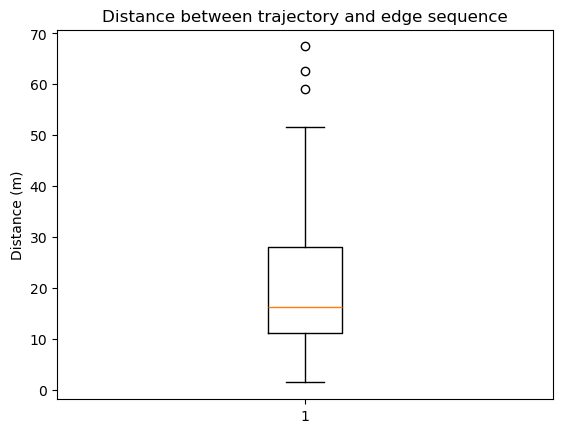

,mmsi,mean_dist,median_dist,max_dist,distances
0,257390900_13_2022-04-03 07:01:36,21.949581,16.330333,67.440586,"[17.04127730472562, 34.20384205051162, 46.7648..."


In [73]:
#########
# find the best path along the graph for a trajectory and evaluate goodness of fit
#########
G = network.G_pruned.copy()
waypoints = network.waypoints.copy()
connections = network.waypoint_connections_pruned.copy()
mmsi = mmsis[0]
trajectory = network.trajectories.get_trajectory(mmsi)
points = trajectory.to_point_gdf()

### GET START POINT ###
# map trajectory start point to the closest waypoint available
orig = points.iloc[0].geometry  # get start point
orig_cog = geometry_utils.calculate_initial_compass_bearing(Point(points.iloc[0].lon, points.iloc[0].lat), 
                                                            Point(points.iloc[9].lon, points.iloc[9].lat)) # get initial cog
mask = np.abs(waypoints.cog_before - orig_cog) < 45  # only consider waypoints that have the same direction
distances = orig.distance(waypoints[mask].geometry)
masked_idx = np.argmin(distances)
orig_WP = waypoints[mask]['clusterID'].iloc[masked_idx]
# find trajectory point that is closest to the centroid of the first waypoint
# this is where we start measuring
orig_WP_point = waypoints[waypoints.clusterID==orig_WP]['geometry'].item()
idx_orig = np.argmin(orig_WP_point.distance(points.geometry))
# Now we have found the first waypoint and the first point on the trajectory closest to that waypoint

### GET END POINT ###
# map trajectory end point to the closest waypoint available
dest = points.iloc[-1].geometry  # get end point
dest_cog = geometry_utils.calculate_initial_compass_bearing(Point(points.iloc[-10].lon, points.iloc[-10].lat), 
                                                            Point(points.iloc[-1].lon, points.iloc[-1].lat)) # get initial cog
mask = np.abs(waypoints.cog_before - dest_cog) < 45  # only consider waypoints that have the same direction
distances = dest.distance(waypoints[mask].geometry)
masked_idx = np.argmin(distances)
dest_WP = waypoints[mask]['clusterID'].iloc[masked_idx]
# find trajectory point that is closest to the centroid of the last waypoint
# this is where we end measuring
dest_WP_point = waypoints[waypoints.clusterID==dest_WP]['geometry'].item()
idx_dest = np.argmin(dest_WP_point.distance(points.geometry))
# Now we have found the last waypoint and the last point on the trajectory closest to that waypoint
print(f'start: {orig_WP}, end: {dest_WP}')

#### Find path between origin and destination
path = [orig_WP]
current_WP = orig_WP
# check if such a path exists
shortest_path = nx.shortest_path(G, orig_WP, dest_WP, weight='inverse_weight')
if len(shortest_path)>0:
    print('path exists')
    print(shortest_path)

# find a path from start to end waypoint
while path[-1] != dest_WP:
    # Check if a next path segment is available
    if len(list(G.neighbors(current_WP))) > 0:
        # iterate over all connected waypoints that the current waypoint is connected to
        # find next waypoint closest to the trajectory
        shortest_mean_distance = np.inf
        for candidate_WP in G.neighbors(current_WP):
            # calculate mean distance between the trajectory and the edge between current and candidate waypoint
            # get edge between current and candidate waypoint
            edge = connections[(connections['from'] == current_WP) & (connections['to'] == candidate_WP)].geometry.item()
            # get trajectory segment between the two waypoints
            # find trajectory point closest to current waypoint
            current_WP_point = waypoints[waypoints.clusterID==current_WP]['geometry'].item()
            distances = points.distance(current_WP_point)  # get coordinates of waypoint centroid)
            p1_idx = np.argmin(distances)
            # find trajectory point closest to candidate waypoint
            candidate_WP_point = waypoints[waypoints.clusterID==candidate_WP]['geometry'].item()
            distances = points.iloc[p1_idx:-1].distance(candidate_WP_point)  # get coordinates of waypoint centroid)
            p2_idx = np.argmin(distances) + p1_idx
            # compute mean distance between trajectory segment and edge
            mean_distance = points[p1_idx:p2_idx].distance(edge).mean()
            # compute trajectory COG close to candidate waypoint
            p2_cog = geometry_utils.calculate_initial_compass_bearing(Point(points.iloc[p2_idx-3].lon, points.iloc[p2_idx-3].lat), 
                                                                      Point(points.iloc[p2_idx].lon, points.iloc[p2_idx].lat))
            # get candidate waypoint traffic direction
            candidate_WP_cog = waypoints[waypoints.clusterID==candidate_WP]['cog_before'].item()
            angle = (p2_cog - candidate_WP_cog + 180) % 360 - 180
            if ((mean_distance < shortest_mean_distance) & (np.abs(angle)<30)):
                next_WP = candidate_WP
                shortest_mean_distance = mean_distance
        if next_WP == current_WP:
            print('Got stuck. Terminating...')
            break
        else:
            path.append(next_WP) # append next waypoint to path
            #G.remove_node(current_WP)  # drop current waypoint from graph to avoid going in circles
            current_WP = next_WP
    else:
        print('No more adjacent waypoints. Terminating...')
        break
print(path)

# make trajectory from path
path_df = pd.DataFrame(columns=['mmsi', 'orig', 'dest', 'geometry'])
for j in range(0, len(path)-1):
    edge = connections[(connections['from'] == path[j]) & (connections['to'] == path[j+1])].geometry.item()
    temp = pd.DataFrame([[mmsi, path[j], path[j+1], edge]], columns=['mmsi', 'orig', 'dest', 'geometry'])
    path_df = pd.concat([path_df, temp])
path_df = gpd.GeoDataFrame(path_df, geometry='geometry', crs=network.crs)

##### EXPERIMENTAL
dijkstra_path_df = pd.DataFrame(columns=['mmsi', 'orig', 'dest', 'geometry'])
for j in range(0, len(shortest_path)-1):
    edge = connections[(connections['from'] == shortest_path[j]) & (connections['to'] == shortest_path[j+1])].geometry.item()
    temp = pd.DataFrame([[mmsi, shortest_path[j], shortest_path[j+1], edge]], columns=['mmsi', 'orig', 'dest', 'geometry'])
    dijkstra_path_df = pd.concat([dijkstra_path_df, temp])
dijkstra_path_df = gpd.GeoDataFrame(dijkstra_path_df, geometry='geometry', crs=network.crs)
###################

###########
# evaluate goodness of fit
###########
from shapely import ops
from shapely.geometry import MultiLineString
eval_points = points.iloc[idx_orig:idx_dest]
multi_line = MultiLineString(list(path_df.geometry))
edge_sequence = ops.linemerge(multi_line)
distances = eval_points.distance(edge_sequence)
mean_dist = distances.mean()
median_dist = distances.median()
max_dist = distances.max()
evaluation_results = pd.DataFrame({'mmsi':mmsi,
                                   'mean_dist':mean_dist,
                                   'median_dist':median_dist,
                                   'max_dist':max_dist,
                                   'distances':[distances.tolist()]})
# report results
plt.boxplot(distances)
plt.title('Distance between trajectory and edge sequence')
plt.ylabel('Distance (m)')
plt.show()
evaluation_results.head()


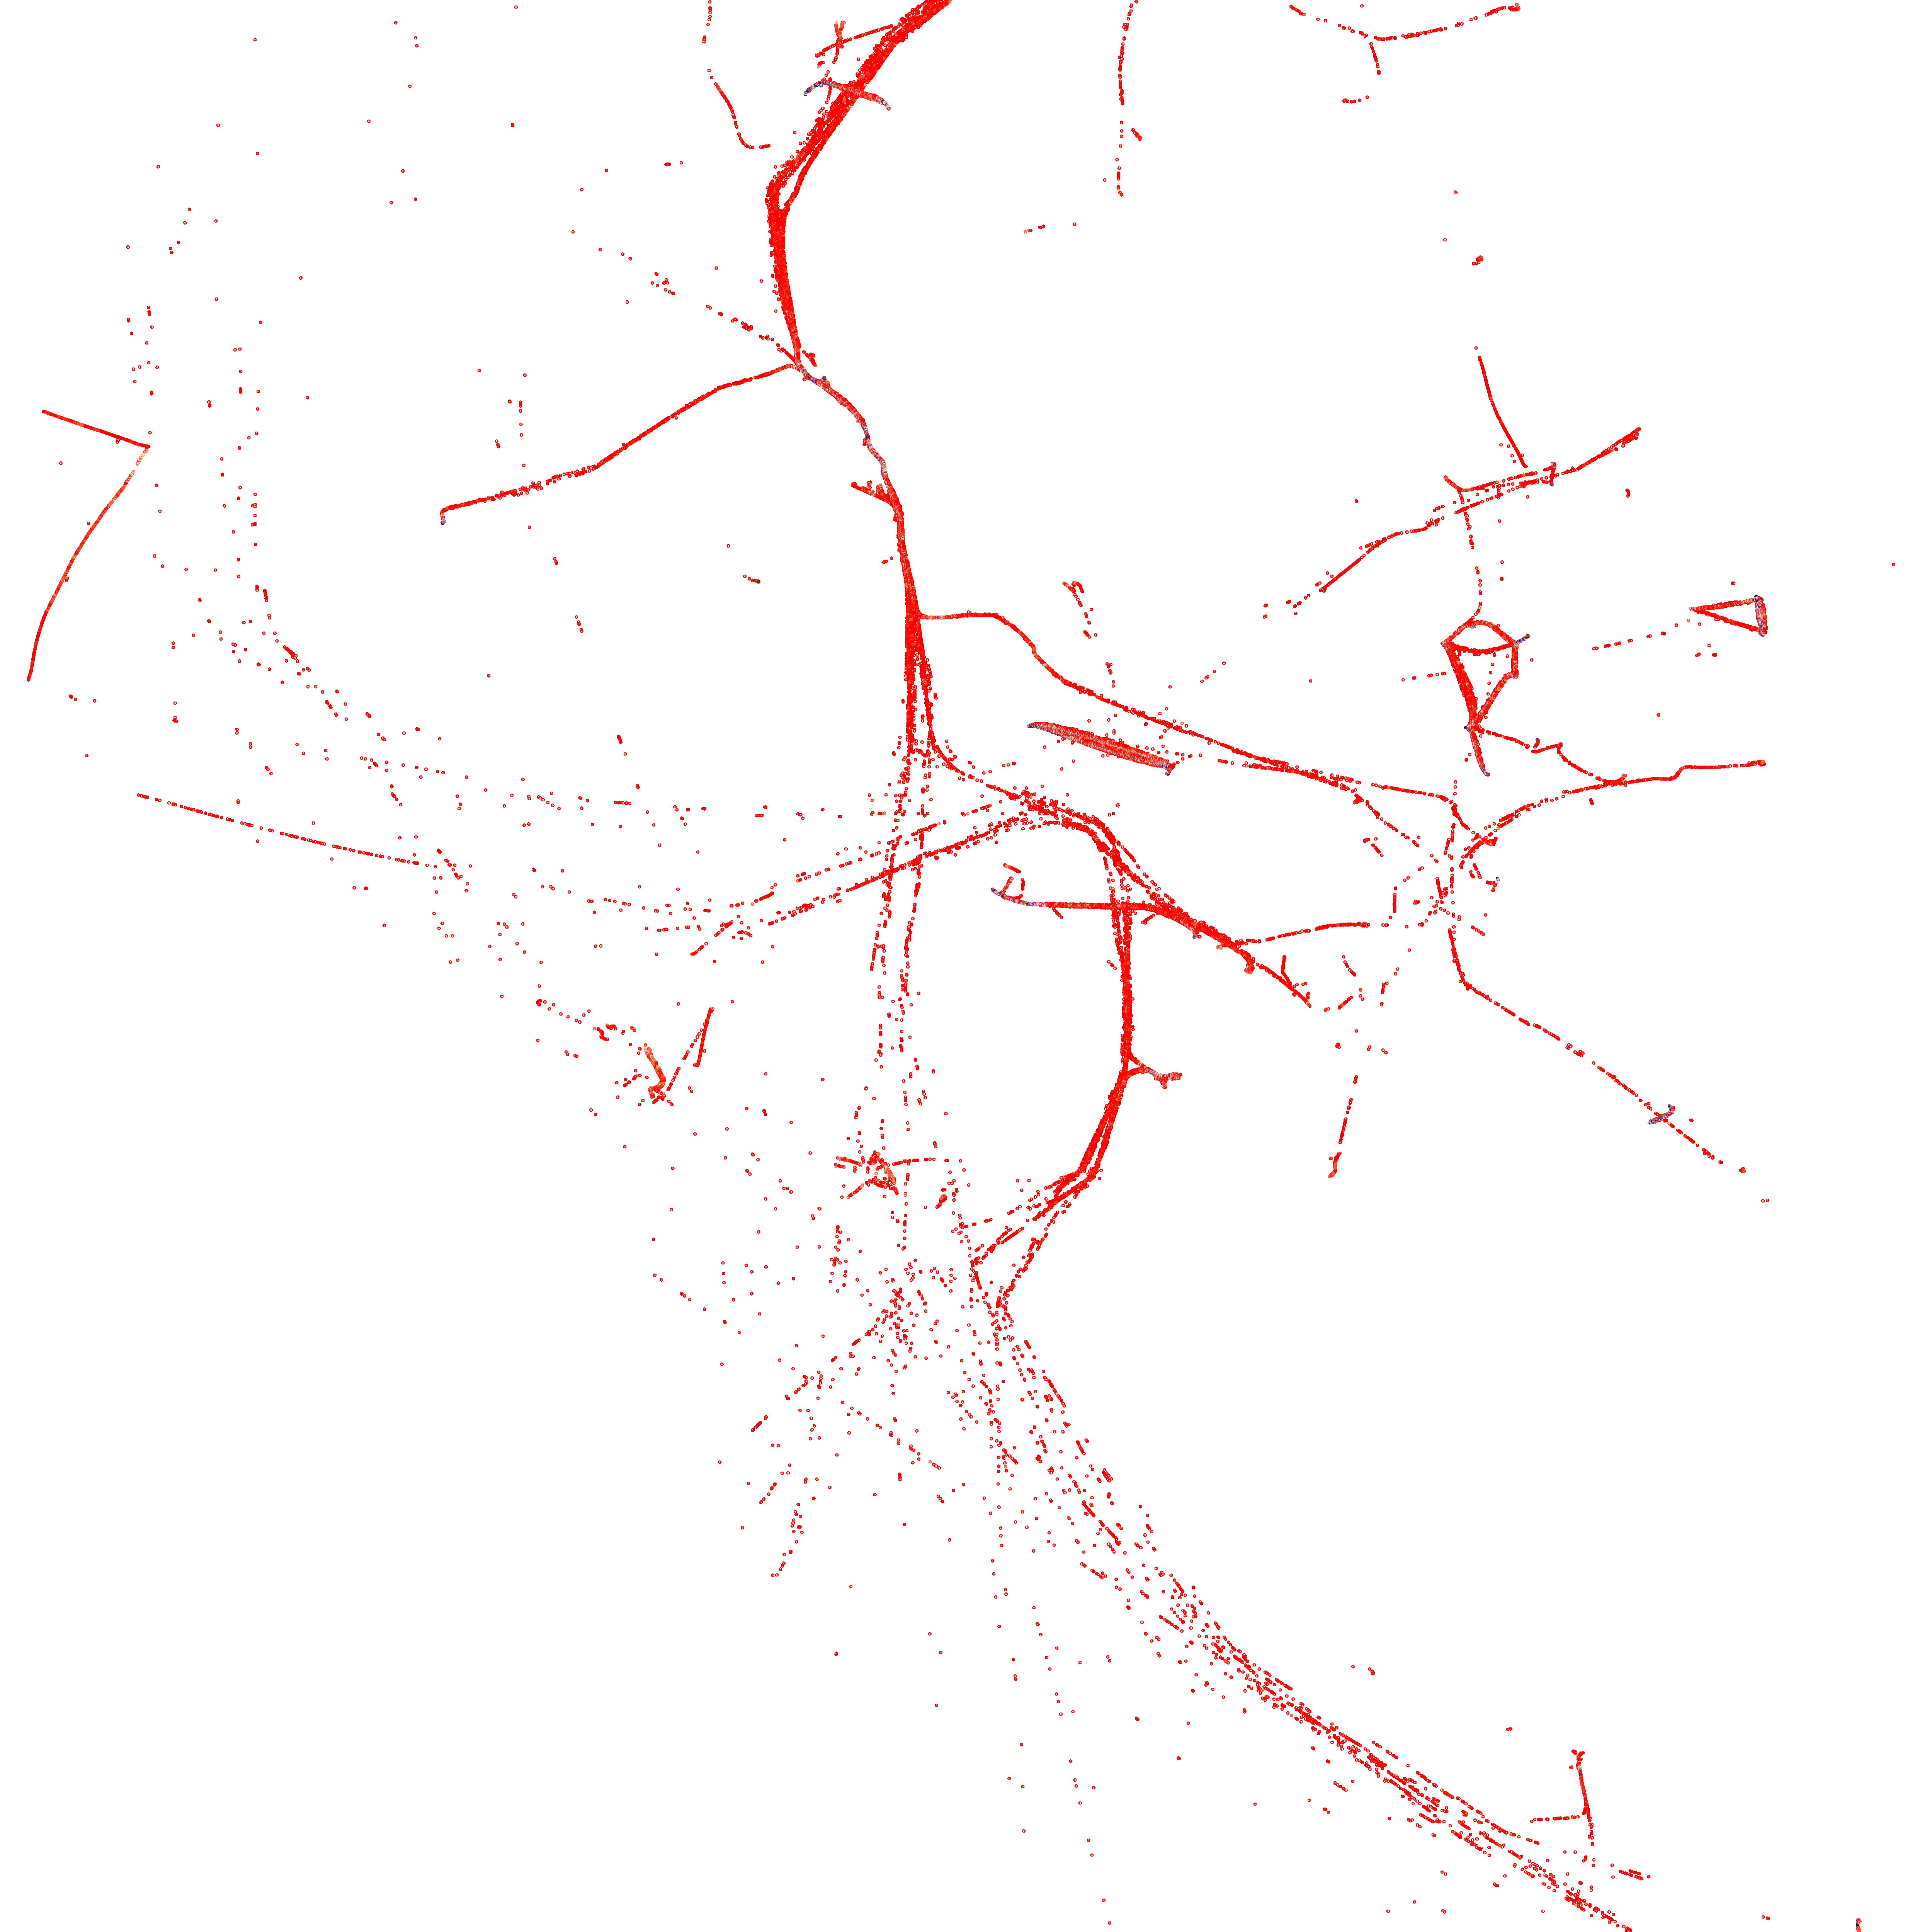

In [74]:
# Generate plot
map = network.map_graph(pruned=True)
map = trajectories.to_line_gdf()[['geometry', 'mmsi']].explore(m=map, style_kwds={'weight':1, 'color':'black', 'opacity':0.5}, 
                                                               name=mmsi)
map = trajectories_points[['geometry', 'mmsi']].explore(m=map, marker_kwds={'radius':1}, 
                                                        style_kwds={'color':'black', 'fillColor':'black', 'fillOpacity':1}, 
                                                        name=mmsi+' points')
map = eval_points.reset_index()[['geometry', 'mmsi']].explore(m=map, color='grey', marker_kwds={'radius':1})
map = path_df.explore(m=map, color='yellow', name=mmsi+' path')
map = dijkstra_path_df.explore(m=map, color='orange', name=mmsi+' dijkstra path')
#map = DP_trajectories[DP_trajectories.mmsi.isin(mmsis)][['geometry', 'mmsi']].explore(m=map, color='black')
#map = DP_points[DP_points.clusterID >= 0][['geometry', 'clusterID', 'mmsi']].explore(m=map, color='pink')
folium.LayerControl().add_to(map)

# add a title
title = f'{method} parameters: min_samples = {min_samples}, metric = {metric}'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(title)   

map.get_root().html.add_child(folium.Element(title_html))

map